In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [23]:
df = pd.read_csv('dataset/Food_Delivery_Times.csv')
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [24]:
cat_cols = ['Weather','Traffic_Level','Time_of_Day','Vehicle_Type']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
#df.head()
df.dropna()
df = df.drop(columns=['Order_ID'])
avg = df['Courier_Experience_yrs'].mean()
df['Courier_Experience_yrs'].fillna(avg, inplace=True)

C:\Users\Maharshi\AppData\Local\Temp\ipykernel_12216\2646193310.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Courier_Experience_yrs'].fillna(avg, inplace=True)


In [25]:
X = df.drop(columns=['Delivery_Time_min'])
y = df['Delivery_Time_min']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [27]:
base_model = DecisionTreeRegressor(random_state=42, max_depth=3)
model = AdaBoostRegressor(estimator=base_model, random_state=42)

In [28]:
model.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
                  random_state=42)

In [35]:
def getmetric(model):
    print("Train R^2:", model.score(X_train, y_train))
    print("Test R^2:", model.score(X_test, y_test))
    y_pred = model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    print(f'Mean square error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Square Error: {rmse}')
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, label='Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, label='Ideal Fit')
    plt.xlabel('Actual Time')
    plt.ylabel('Predicted Time')
    plt.title('Predicted vs Actual Delivery Times')
    plt.legend()
    plt.show()

Train R^2: 0.5315455635662041
Test R^2: 0.42046071728718293
Mean square error: 250.309558558235
Mean Absolute Error: 13.700845057900175
Root Mean Square Error: 15.821174373548729


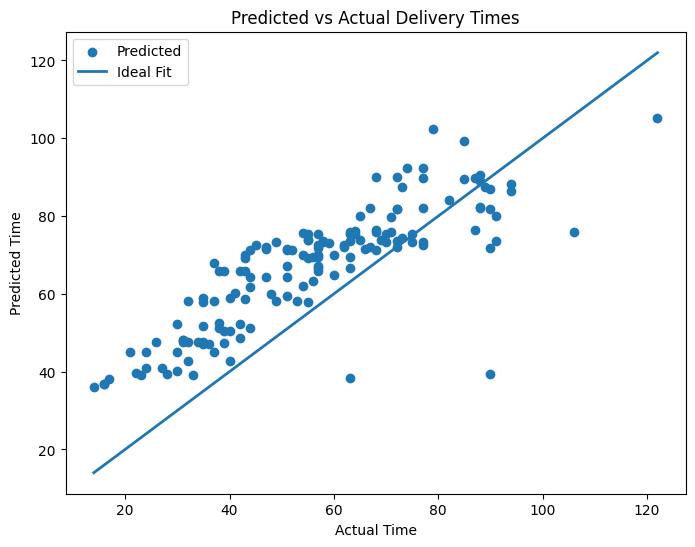

In [30]:
getmetric(model)

In [33]:
# Hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 1),
    'estimator__max_depth': randint(2, 6),
    'loss': ['linear', 'square', 'exponential']
}

In [34]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best params: {'estimator__max_depth': 5, 'learning_rate': 0.0155221171236024, 'loss': 'exponential', 'n_estimators': 292}
Best score: 146.83327743240494


Train R^2: -93.8357628431824
Test R^2: -133.4991412134111
Mean square error: 133.4991412134111
Mean Absolute Error: 8.059244573886852
Root Mean Square Error: 11.554182844901282


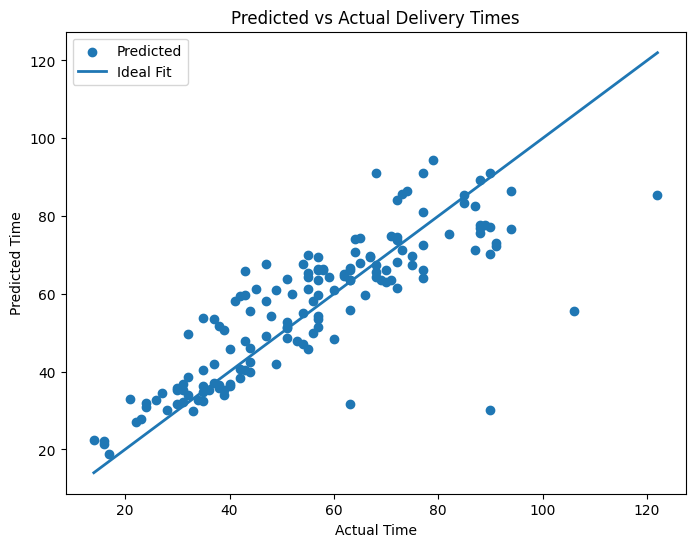

In [36]:
getmetric(random_search)